In [68]:
import cv2
import numpy as np
import os
from sklearn.svm import LinearSVC
from sklearn.externals import joblib
from scipy.cluster.vq import *
import seaborn as sns

from sklearn.preprocessing import StandardScaler
import glob
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import mahotas
import mahotas.features
import milk
from jug import TaskGenerator
from skimage import data
from skimage.feature import hog

%matplotlib inline
#from helper import *
import helper
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.cross_validation import StratifiedShuffleSplit
from functools import partial
import datetime
import pickle

In [66]:
# sklearn models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import scale

# sklearn metrics
from sklearn.metrics import *
from sklearn.learning_curve import learning_curve
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
train_folder= 'data/train'
train_label='data/trainLabels.csv'

In [5]:
all_train_df= helper.get_cifar_training_data(train_folder,train_label)
all_train_df.head()

,id,label,filename,full_filename
0,1,frog,1.png,data/train\1.png
1,2,truck,2.png,data/train\2.png
2,3,truck,3.png,data/train\3.png
3,4,deer,4.png,data/train\4.png
4,5,automobile,5.png,data/train\5.png


In [6]:
split_idxes=next(iter(StratifiedShuffleSplit(all_train_df['label'],n_iter =1,test_size=0.30,random_state=20)))
train_index, test_index = split_idxes

In [7]:
features=all_train_df[['id','filename','full_filename']]
labels=all_train_df['label']


In [8]:
train_img_gen=helper.load_images(features['full_filename'])

In [9]:
X_train_df,X_test_df,y_train,y_test= helper.get_stratified_train_test_split(
    features,labels)

In [10]:
X_train_df.head()

,id,filename,full_filename
1401,1402,1402.png,data/train\1402.png
168,169,169.png,data/train\169.png
46471,46472,46472.png,data/train\46472.png
37950,37951,37951.png,data/train\37951.png
26285,26286,26286.png,data/train\26286.png


In [11]:
X_test_df.head()

,id,filename,full_filename
39264,39265,39265.png,data/train\39265.png
18869,18870,18870.png,data/train\18870.png
11313,11314,11314.png,data/train\11314.png
26085,26086,26086.png,data/train\26086.png
22976,22977,22977.png,data/train\22977.png


In [12]:
cch_1= helper.ColorChannelStatistics(sub_regions=1)
cch_2= helper.ColorChannelStatistics(sub_regions=2)
cch_4= helper.ColorChannelStatistics(sub_regions=4)

cc_pipeline = FeatureUnion([("cch_1", cch_1),("cch_2", cch_2),("cch_4", cch_4)])
hog_pipeline= Pipeline([("gt", helper.GrayScaleImageTransform())
                        ,("ht", helper.HogStatistics())])

In [13]:
train_img_gen=helper.load_images(X_train_df['full_filename'])
test_img_gen=helper.load_images(X_test_df['full_filename'])


In [14]:
feature_extractors=[cc_pipeline,hog_pipeline]
#X_train=helper.extract_image_features(train_img_gen,feature_extractors)
#X_test=helper.extract_image_features(test_img_gen,feature_extractors)


2015-08-02 13:27:12.362000


In [34]:
print(datetime.datetime.now())
X_train=helper.extract_multiple_image_features(feature_extractors,X_train_df['full_filename'])
print(datetime.datetime.now())

2015-08-02 13:27:48.760000
2015-08-02 13:44:36.570000


In [72]:
print(datetime.datetime.now())
X_test=helper.extract_multiple_image_features(feature_extractors,X_test_df['full_filename'])
print(datetime.datetime.now())

2015-08-02 16:14:17.020000
2015-08-02 16:21:48.157000


In [73]:
pickle.dump(X_train,open('Xtrain.pkl',"wb"))
pickle.dump(X_test,open('Xtest.pkl',"wb"))

In [74]:
X_train = pickle.load(open('Xtrain.pkl',"rb"))
X_test = pickle.load(open('Xtest.pkl',"rb"))

In [30]:
len(X_train)

5

In [35]:
X_train[0]

array([[  7.75830078e+01,   4.24613904e+01,   9.44482422e+01,
          4.64459874e+01,   8.43085938e+01,   5.09237950e+01,
          8.41171875e+01,   3.33083654e+01,   1.02320312e+02,
          4.55013622e+01,   5.87500000e+01,   3.96352510e+01,
          6.51445312e+01,   3.60149520e+01,   1.02378906e+02,
          3.66605121e+01,   1.24386719e+02,   5.48591490e+01,
          6.92031250e+01,   3.46465094e+01,   8.18242188e+01,
          3.63198191e+01,   8.42851562e+01,   3.60299454e+01,
          1.08230469e+02,   5.10742949e+01,   6.93554688e+01,
          5.44265077e+01,   7.53632812e+01,   5.12647545e+01,
          1.18562500e+02,   2.43149099e+01,   4.68750000e+01,
          2.02403526e+01,   7.54375000e+01,   4.18519993e+01,
          3.47812500e+01,   1.28749621e+01,   1.08953125e+02,
          4.30226792e+01,   5.27500000e+01,   3.36976446e+01,
          8.55156250e+01,   2.97184666e+01,   8.74218750e+01,
          3.15276687e+01,   1.17468750e+02,   3.56339764e+01,
        

In [75]:
X_train_simp=map(lambda x:x[0], X_train)
X_test_simp=map(lambda x:x[0], X_test)

In [32]:
models = {'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5), 
          'Gaussian Naive Bayes': GaussianNB(),
          'Random Forest Classifier': RandomForestClassifier(),
          'Bernoulli Naive Bayes': BernoulliNB(),
          'Support Vector Machine': SVC()
         }

In [56]:
model = KNeighborsClassifier(n_neighbors=5).fit(X_train_simp, y_train)


In [80]:
y_predicted=model.predict(X_test_simp)

In [94]:
classification_report(y_test, y_predicted)

'             precision    recall  f1-score   support\n\n   airplane       1.00      0.01      0.01      1500\n automobile       1.00      0.01      0.02      1500\n       bird       0.10      1.00      0.18      1500\n        cat       1.00      0.00      0.01      1500\n       deer       1.00      0.01      0.02      1500\n        dog       1.00      0.00      0.00      1500\n       frog       1.00      0.01      0.03      1500\n      horse       1.00      0.00      0.00      1500\n       ship       1.00      0.00      0.00      1500\n      truck       1.00      0.00      0.01      1500\n\navg / total       0.91      0.11      0.03     15000\n'

0.4074


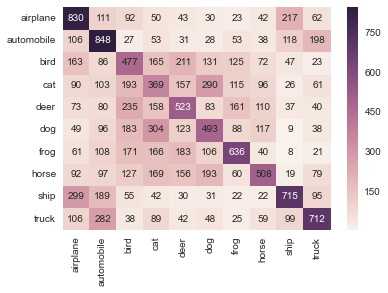

In [103]:
label_names = model.classes_
cm = confusion_matrix(y_test, y_predicted)
sns.heatmap(cm,  annot=True,  fmt='', xticklabels=label_names, yticklabels=label_names);
print(accuracy_score(y_test, y_predicted))
#print(roc_auc_score(y_test, y_predicted))

0.480733333333


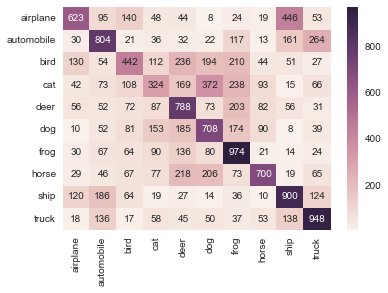

In [105]:
model=GaussianNB().fit(X_train_simp, y_train)
y_predicted=model.predict(X_test_simp)
label_names = model.classes_
cm = confusion_matrix(y_test, y_predicted)
sns.heatmap(cm, annot=True,fmt='', xticklabels=label_names, yticklabels=label_names);
print(accuracy_score(y_test, y_predicted))
#print(roc_auc_score(y_test, y_predicted))

0.409133333333


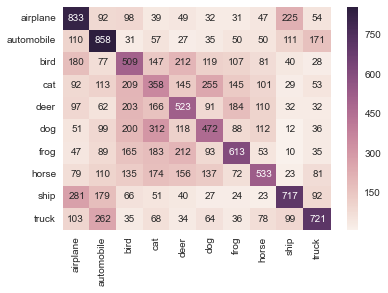

In [106]:
model=RandomForestClassifier().fit(X_train_simp, y_train)
y_predicted=model.predict(X_test_simp)
label_names = model.  
cm = confusion_matrix(y_test, y_predicted)
sns.heatmap(cm, annot=True,  fmt='', xticklabels=label_names, yticklabels=label_names);
print(accuracy_score(y_test, y_predicted))
#print(roc_auc_score(y_test, y_predicted))

0.2096


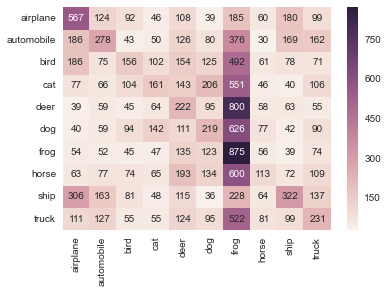

In [107]:
model=BernoulliNB().fit(X_train_simp, y_train)
y_predicted=model.predict(X_test_simp)
label_names = model.classes_
cm = confusion_matrix(y_test, y_predicted)
sns.heatmap(cm, annot=True,  fmt='', xticklabels=label_names, yticklabels=label_names);
print(accuracy_score(y_test, y_predicted))
#print(roc_auc_score(y_test, y_predicted))

0.105533333333


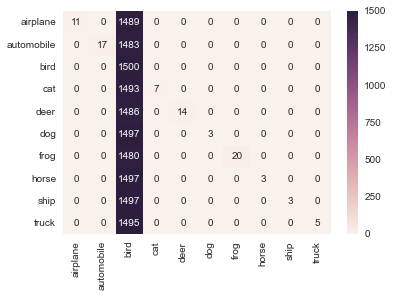

In [108]:
model=SVC().fit(X_train_simp, y_train)
y_predicted=model.predict(X_test_simp)
label_names = model.classes_
cm = confusion_matrix(y_test, y_predicted)
sns.heatmap(cm, annot=True,  fmt='', xticklabels=label_names, yticklabels=label_names);
print(accuracy_score(y_test, y_predicted))
#print(roc_auc_score(y_test, y_predicted))